### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 15  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")



Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:14<103:44:05, 74.70s/it]

Entrenando:   0%|          | 2/5000 [02:28<102:46:07, 74.02s/it]

Entrenando:   0%|          | 3/5000 [03:41<102:27:59, 73.82s/it]

Entrenando:   0%|          | 4/5000 [04:50<99:21:08, 71.59s/it] 

Entrenando:   0%|          | 5/5000 [06:03<100:09:45, 72.19s/it]

Entrenando:   0%|          | 6/5000 [07:11<98:22:59, 70.92s/it] 

Entrenando:   0%|          | 7/5000 [08:23<98:54:25, 71.31s/it]

Entrenando:   0%|          | 8/5000 [09:32<97:32:33, 70.34s/it]

Entrenando:   0%|          | 9/5000 [10:42<97:19:54, 70.21s/it]

Entrenando:   0%|          | 10/5000 [11:55<98:53:51, 71.35s/it]

Entrenando:   0%|          | 11/5000 [13:05<98:09:23, 70.83s/it]

Entrenando:   0%|          | 12/5000 [14:13<97:03:41, 70.05s/it]

Entrenando:   0%|          | 13/5000 [15:27<98:31:42, 71.13s/it]

Entrenando:   0%|          | 14/5000 [16:37<98:05:40, 70.83s/it]

Entrenando:   0%|          | 15/5000 [17:46<97:06:31, 70.13s/it]

Entrenando:   0%|          | 16/5000 [18:56<97:18:40, 70.29s/it]

Entrenando:   0%|          | 17/5000 [20:31<107:20:30, 77.55s/it]

Entrenando:   0%|          | 18/5000 [22:14<118:11:49, 85.41s/it]

Entrenando:   0%|          | 19/5000 [24:16<133:03:04, 96.16s/it]

Entrenando:   0%|          | 20/5000 [26:01<136:54:02, 98.96s/it]

Entrenando:   0%|          | 21/5000 [27:42<137:48:39, 99.64s/it]

Entrenando:   0%|          | 22/5000 [29:39<144:56:23, 104.82s/it]

Entrenando:   0%|          | 23/5000 [31:25<145:11:30, 105.02s/it]

Entrenando:   0%|          | 24/5000 [33:00<141:05:58, 102.08s/it]

Entrenando:   0%|          | 25/5000 [35:03<149:57:31, 108.51s/it]

Entrenando:   1%|          | 26/5000 [38:01<178:43:11, 129.35s/it]

Entrenando:   1%|          | 27/5000 [40:44<192:19:20, 139.22s/it]

Entrenando:   1%|          | 28/5000 [43:31<203:45:35, 147.53s/it]

Entrenando:   1%|          | 29/5000 [46:30<217:06:30, 157.23s/it]

Entrenando:   1%|          | 30/5000 [49:26<224:47:25, 162.83s/it]

Entrenando:   1%|          | 31/5000 [52:20<229:03:57, 165.96s/it]

Entrenando:   1%|          | 32/5000 [55:03<227:59:43, 165.21s/it]

Entrenando:   1%|          | 33/5000 [58:38<248:24:23, 180.04s/it]

Entrenando:   1%|          | 34/5000 [1:02:29<269:24:27, 195.30s/it]

Entrenando:   1%|          | 35/5000 [1:06:28<287:33:57, 208.51s/it]

Entrenando:   1%|          | 36/5000 [1:10:28<300:37:38, 218.02s/it]

Entrenando:   1%|          | 37/5000 [1:14:23<307:22:37, 222.96s/it]

Entrenando:   1%|          | 38/5000 [1:18:18<312:28:11, 226.70s/it]

Entrenando:   1%|          | 39/5000 [1:22:12<315:22:08, 228.85s/it]

Entrenando:   1%|          | 40/5000 [1:26:02<315:41:30, 229.13s/it]

Entrenando:   1%|          | 41/5000 [1:29:50<315:24:05, 228.97s/it]

Entrenando:   1%|          | 42/5000 [1:33:38<314:56:59, 228.68s/it]

Entrenando:   1%|          | 43/5000 [1:37:25<314:05:35, 228.11s/it]

Entrenando:   1%|          | 44/5000 [1:41:11<313:17:56, 227.58s/it]

Entrenando:   1%|          | 45/5000 [1:44:57<312:28:24, 227.02s/it]

Entrenando:   1%|          | 46/5000 [1:48:31<307:04:30, 223.15s/it]

Entrenando:   1%|          | 47/5000 [1:52:04<302:34:05, 219.92s/it]

Entrenando:   1%|          | 48/5000 [1:55:19<292:15:43, 212.47s/it]

Entrenando:   1%|          | 49/5000 [1:58:16<277:34:55, 201.84s/it]

Entrenando:   1%|          | 50/5000 [2:01:15<268:03:50, 194.96s/it]

Iter  50: train_loss=3.5118, val_loss=3.4101, train_suc=0.670, train_err=0.175, train_inc=0.155 | val_suc=0.653, val_err=0.182, val_inc=0.165


Entrenando:   1%|          | 51/5000 [2:04:08<259:15:45, 188.59s/it]

Entrenando:   1%|          | 52/5000 [2:07:36<266:51:59, 194.16s/it]

Entrenando:   1%|          | 53/5000 [2:10:25<256:26:04, 186.61s/it]

Entrenando:   1%|          | 54/5000 [2:13:28<254:55:31, 185.55s/it]

Entrenando:   1%|          | 55/5000 [2:16:14<247:10:13, 179.94s/it]

Entrenando:   1%|          | 56/5000 [2:18:54<238:41:15, 173.80s/it]

Entrenando:   1%|          | 57/5000 [2:21:34<232:58:31, 169.68s/it]

Entrenando:   1%|          | 58/5000 [2:24:10<227:11:29, 165.50s/it]

Entrenando:   1%|          | 59/5000 [2:26:58<228:15:43, 166.31s/it]

Entrenando:   1%|          | 60/5000 [2:29:37<225:24:00, 164.26s/it]

Entrenando:   1%|          | 61/5000 [2:32:18<223:48:48, 163.14s/it]

Entrenando:   1%|          | 62/5000 [2:34:57<221:57:38, 161.82s/it]

Entrenando:   1%|▏         | 63/5000 [2:37:34<220:02:55, 160.46s/it]

Entrenando:   1%|▏         | 64/5000 [2:40:05<216:17:32, 157.75s/it]

Entrenando:   1%|▏         | 65/5000 [2:42:29<210:23:40, 153.48s/it]

Entrenando:   1%|▏         | 66/5000 [2:44:52<206:04:53, 150.36s/it]

Entrenando:   1%|▏         | 67/5000 [2:47:11<201:17:38, 146.90s/it]

Entrenando:   1%|▏         | 68/5000 [2:49:28<197:04:06, 143.85s/it]

Entrenando:   1%|▏         | 69/5000 [2:51:34<189:57:05, 138.68s/it]

Entrenando:   1%|▏         | 70/5000 [2:53:34<182:03:51, 132.95s/it]

Entrenando:   1%|▏         | 71/5000 [2:55:41<179:37:20, 131.19s/it]

Entrenando:   1%|▏         | 72/5000 [2:57:48<177:47:29, 129.88s/it]

Entrenando:   1%|▏         | 73/5000 [2:59:51<175:08:42, 127.97s/it]

Entrenando:   1%|▏         | 74/5000 [3:01:44<168:43:26, 123.31s/it]

Entrenando:   2%|▏         | 75/5000 [3:03:52<170:35:28, 124.70s/it]

Entrenando:   2%|▏         | 76/5000 [3:05:48<167:11:25, 122.24s/it]

Entrenando:   2%|▏         | 77/5000 [3:07:53<168:12:03, 123.00s/it]

Entrenando:   2%|▏         | 78/5000 [3:09:52<166:31:04, 121.79s/it]

Entrenando:   2%|▏         | 79/5000 [3:11:49<164:27:00, 120.30s/it]

Entrenando:   2%|▏         | 80/5000 [3:13:37<159:37:43, 116.80s/it]

Entrenando:   2%|▏         | 81/5000 [3:15:40<162:02:08, 118.59s/it]

Entrenando:   2%|▏         | 82/5000 [3:17:32<159:07:26, 116.48s/it]

Entrenando:   2%|▏         | 83/5000 [3:19:26<158:23:26, 115.97s/it]

Entrenando:   2%|▏         | 84/5000 [3:21:35<163:31:29, 119.75s/it]

Entrenando:   2%|▏         | 85/5000 [3:23:41<165:55:13, 121.53s/it]

Entrenando:   2%|▏         | 86/5000 [3:25:42<165:44:07, 121.42s/it]

Entrenando:   2%|▏         | 87/5000 [3:27:38<163:27:15, 119.77s/it]

Entrenando:   2%|▏         | 88/5000 [3:29:37<163:15:29, 119.65s/it]

Entrenando:   2%|▏         | 89/5000 [3:31:44<166:17:20, 121.90s/it]

Entrenando:   2%|▏         | 90/5000 [3:33:56<170:23:00, 124.92s/it]

Entrenando:   2%|▏         | 91/5000 [3:36:05<172:04:48, 126.19s/it]

Entrenando:   2%|▏         | 92/5000 [3:38:13<172:49:38, 126.77s/it]

Entrenando:   2%|▏         | 93/5000 [3:40:21<173:08:25, 127.02s/it]

Entrenando:   2%|▏         | 94/5000 [3:42:15<167:44:14, 123.08s/it]

Entrenando:   2%|▏         | 95/5000 [3:44:24<170:06:40, 124.85s/it]

Entrenando:   2%|▏         | 96/5000 [3:46:24<168:13:13, 123.49s/it]

Entrenando:   2%|▏         | 97/5000 [3:48:26<167:35:49, 123.06s/it]

Entrenando:   2%|▏         | 98/5000 [3:50:26<166:12:28, 122.06s/it]

Entrenando:   2%|▏         | 99/5000 [3:52:19<162:29:49, 119.36s/it]

Entrenando:   2%|▏         | 100/5000 [3:54:16<161:17:22, 118.50s/it]

Iter 100: train_loss=1.7708, val_loss=1.7823, train_suc=0.678, train_err=0.056, train_inc=0.266 | val_suc=0.658, val_err=0.058, val_inc=0.284
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [3:56:27<166:24:43, 122.29s/it]

Entrenando:   2%|▏         | 102/5000 [3:58:25<164:56:42, 121.23s/it]

Entrenando:   2%|▏         | 103/5000 [4:00:26<164:26:31, 120.89s/it]

Entrenando:   2%|▏         | 104/5000 [4:02:37<168:51:23, 124.16s/it]

Entrenando:   2%|▏         | 105/5000 [4:04:39<167:42:24, 123.34s/it]

Entrenando:   2%|▏         | 106/5000 [4:06:39<166:22:30, 122.38s/it]

Entrenando:   2%|▏         | 107/5000 [4:08:42<166:28:20, 122.48s/it]

Entrenando:   2%|▏         | 108/5000 [4:10:33<161:57:10, 119.18s/it]

Entrenando:   2%|▏         | 109/5000 [4:12:36<163:21:44, 120.24s/it]

Entrenando:   2%|▏         | 110/5000 [4:14:39<164:24:46, 121.04s/it]

Entrenando:   2%|▏         | 111/5000 [4:16:25<158:26:16, 116.67s/it]

Entrenando:   2%|▏         | 112/5000 [4:18:25<159:49:11, 117.71s/it]

Entrenando:   2%|▏         | 113/5000 [4:20:30<162:39:30, 119.82s/it]

Entrenando:   2%|▏         | 114/5000 [4:22:26<161:05:00, 118.69s/it]

Entrenando:   2%|▏         | 115/5000 [4:24:34<164:37:45, 121.32s/it]

Entrenando:   2%|▏         | 116/5000 [4:26:39<166:11:21, 122.50s/it]

Entrenando:   2%|▏         | 117/5000 [4:28:56<171:57:42, 126.78s/it]

Entrenando:   2%|▏         | 118/5000 [4:31:07<173:44:21, 128.12s/it]

Entrenando:   2%|▏         | 119/5000 [4:33:13<172:55:52, 127.55s/it]

Entrenando:   2%|▏         | 120/5000 [4:35:22<173:33:14, 128.03s/it]

Entrenando:   2%|▏         | 121/5000 [4:37:36<176:01:18, 129.88s/it]

Entrenando:   2%|▏         | 122/5000 [4:39:40<173:16:07, 127.87s/it]

Entrenando:   2%|▏         | 123/5000 [4:41:49<173:45:01, 128.26s/it]

Entrenando:   2%|▏         | 124/5000 [4:44:02<175:37:52, 129.67s/it]

Entrenando:   2%|▎         | 125/5000 [4:46:15<176:51:54, 130.61s/it]

Entrenando:   3%|▎         | 126/5000 [4:48:28<177:47:58, 131.32s/it]

Entrenando:   3%|▎         | 127/5000 [4:50:29<173:53:27, 128.46s/it]

Entrenando:   3%|▎         | 128/5000 [4:52:40<174:38:17, 129.04s/it]

Entrenando:   3%|▎         | 129/5000 [4:54:49<174:47:42, 129.19s/it]

Entrenando:   3%|▎         | 130/5000 [4:56:49<170:57:38, 126.38s/it]

Entrenando:   3%|▎         | 131/5000 [4:58:42<165:39:28, 122.48s/it]

Entrenando:   3%|▎         | 132/5000 [5:00:46<165:57:27, 122.73s/it]

Entrenando:   3%|▎         | 133/5000 [5:03:00<170:25:35, 126.06s/it]

Entrenando:   3%|▎         | 134/5000 [5:04:54<165:49:09, 122.68s/it]

Entrenando:   3%|▎         | 135/5000 [5:06:58<166:02:32, 122.87s/it]

Entrenando:   3%|▎         | 136/5000 [5:08:54<163:15:08, 120.83s/it]

Entrenando:   3%|▎         | 137/5000 [5:11:04<166:51:24, 123.52s/it]

Entrenando:   3%|▎         | 138/5000 [5:13:08<167:19:07, 123.89s/it]

Entrenando:   3%|▎         | 139/5000 [5:15:47<181:23:24, 134.34s/it]

Entrenando:   3%|▎         | 140/5000 [5:19:17<211:50:36, 156.92s/it]

Entrenando:   3%|▎         | 141/5000 [5:22:43<231:51:02, 171.78s/it]

Entrenando:   3%|▎         | 142/5000 [5:26:05<243:53:13, 180.73s/it]

Entrenando:   3%|▎         | 143/5000 [5:29:29<253:28:15, 187.87s/it]

Entrenando:   3%|▎         | 144/5000 [5:32:53<259:54:30, 192.68s/it]

Entrenando:   3%|▎         | 145/5000 [5:36:10<261:28:01, 193.88s/it]

Entrenando:   3%|▎         | 146/5000 [5:39:42<268:37:22, 199.23s/it]

Entrenando:   3%|▎         | 147/5000 [5:43:15<274:26:05, 203.58s/it]

Entrenando:   3%|▎         | 148/5000 [5:46:58<282:03:33, 209.28s/it]

Entrenando:   3%|▎         | 149/5000 [5:50:39<286:36:23, 212.69s/it]

Entrenando:   3%|▎         | 150/5000 [5:54:11<286:22:42, 212.57s/it]

Iter 150: train_loss=1.0397, val_loss=0.9695, train_suc=0.708, train_err=0.003, train_inc=0.289 | val_suc=0.690, val_err=0.003, val_inc=0.308


Entrenando:   3%|▎         | 151/5000 [5:57:45<287:07:07, 213.16s/it]

Entrenando:   3%|▎         | 152/5000 [6:01:21<287:59:24, 213.85s/it]

Entrenando:   3%|▎         | 153/5000 [6:04:54<287:28:32, 213.52s/it]

Entrenando:   3%|▎         | 154/5000 [6:08:24<286:06:53, 212.55s/it]

Entrenando:   3%|▎         | 155/5000 [6:11:58<286:42:05, 213.03s/it]

Entrenando:   3%|▎         | 156/5000 [6:15:34<287:42:44, 213.82s/it]

Entrenando:   3%|▎         | 157/5000 [6:19:10<288:32:04, 214.48s/it]

Entrenando:   3%|▎         | 158/5000 [6:22:44<288:16:06, 214.33s/it]

Entrenando:   3%|▎         | 159/5000 [6:26:18<288:09:19, 214.29s/it]

Entrenando:   3%|▎         | 160/5000 [6:29:36<281:41:10, 209.52s/it]

Entrenando:   3%|▎         | 161/5000 [6:32:55<277:08:33, 206.18s/it]

Entrenando:   3%|▎         | 162/5000 [6:35:54<266:28:42, 198.29s/it]

Entrenando:   3%|▎         | 163/5000 [6:38:54<258:55:03, 192.70s/it]

Entrenando:   3%|▎         | 164/5000 [6:41:57<254:56:54, 189.79s/it]

Entrenando:   3%|▎         | 165/5000 [6:45:07<254:52:15, 189.77s/it]

Entrenando:   3%|▎         | 166/5000 [6:48:05<250:04:45, 186.24s/it]

Entrenando:   3%|▎         | 167/5000 [6:50:42<238:26:23, 177.61s/it]

Entrenando:   3%|▎         | 168/5000 [6:53:26<232:45:38, 173.41s/it]

Entrenando:   3%|▎         | 169/5000 [6:56:04<226:24:35, 168.72s/it]

Entrenando:   3%|▎         | 170/5000 [6:58:33<218:33:21, 162.90s/it]

Entrenando:   3%|▎         | 171/5000 [7:01:01<212:27:46, 158.39s/it]

Entrenando:   3%|▎         | 172/5000 [7:03:24<206:12:42, 153.76s/it]

Entrenando:   3%|▎         | 173/5000 [7:05:46<201:25:17, 150.22s/it]

Entrenando:   3%|▎         | 174/5000 [7:08:08<198:05:54, 147.77s/it]

Entrenando:   4%|▎         | 175/5000 [7:10:23<192:54:56, 143.94s/it]

Entrenando:   4%|▎         | 176/5000 [7:12:40<189:57:34, 141.76s/it]

Entrenando:   4%|▎         | 177/5000 [7:14:52<186:18:08, 139.06s/it]

Entrenando:   4%|▎         | 178/5000 [7:17:04<183:14:37, 136.81s/it]

Entrenando:   4%|▎         | 179/5000 [7:19:13<180:13:52, 134.58s/it]

Entrenando:   4%|▎         | 180/5000 [7:21:15<174:54:29, 130.64s/it]

Entrenando:   4%|▎         | 181/5000 [7:23:15<170:33:25, 127.41s/it]

Entrenando:   4%|▎         | 182/5000 [7:25:16<167:56:34, 125.49s/it]

Entrenando:   4%|▎         | 183/5000 [7:27:22<168:12:49, 125.72s/it]

Entrenando:   4%|▎         | 184/5000 [7:29:33<170:19:20, 127.32s/it]

Entrenando:   4%|▎         | 185/5000 [7:31:49<173:53:58, 130.02s/it]

Entrenando:   4%|▎         | 186/5000 [7:34:05<176:21:43, 131.89s/it]

Entrenando:   4%|▎         | 187/5000 [7:36:20<177:32:30, 132.80s/it]

Entrenando:   4%|▍         | 188/5000 [7:38:32<176:57:40, 132.39s/it]

Entrenando:   4%|▍         | 189/5000 [7:40:44<176:52:55, 132.36s/it]

Entrenando:   4%|▍         | 190/5000 [7:42:59<177:42:51, 133.01s/it]

Entrenando:   4%|▍         | 191/5000 [7:45:13<178:04:11, 133.30s/it]

Entrenando:   4%|▍         | 192/5000 [7:47:29<179:25:54, 134.35s/it]

Entrenando:   4%|▍         | 193/5000 [7:49:46<180:27:25, 135.15s/it]

Entrenando:   4%|▍         | 194/5000 [7:51:59<179:19:17, 134.32s/it]

Entrenando:   4%|▍         | 195/5000 [7:53:57<172:50:12, 129.49s/it]

Entrenando:   4%|▍         | 196/5000 [7:56:02<170:56:49, 128.10s/it]

Entrenando:   4%|▍         | 197/5000 [7:58:08<170:04:39, 127.48s/it]

Entrenando:   4%|▍         | 198/5000 [8:00:11<168:18:56, 126.18s/it]

Entrenando:   4%|▍         | 199/5000 [8:02:11<165:35:26, 124.17s/it]

Entrenando:   4%|▍         | 200/5000 [8:04:18<167:01:09, 125.26s/it]

Iter 200: train_loss=0.8203, val_loss=0.8126, train_suc=0.746, train_err=0.001, train_inc=0.253 | val_suc=0.731, val_err=0.001, val_inc=0.268
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [8:06:19<165:04:31, 123.83s/it]

Entrenando:   4%|▍         | 202/5000 [8:08:27<166:46:26, 125.13s/it]

Entrenando:   4%|▍         | 203/5000 [8:10:29<165:29:27, 124.20s/it]

Entrenando:   4%|▍         | 204/5000 [8:12:39<167:54:39, 126.04s/it]

Entrenando:   4%|▍         | 205/5000 [8:14:50<169:32:52, 127.29s/it]

Entrenando:   4%|▍         | 206/5000 [8:16:48<166:08:25, 124.76s/it]

Entrenando:   4%|▍         | 207/5000 [8:18:53<165:57:04, 124.65s/it]

Entrenando:   4%|▍         | 208/5000 [8:20:52<163:45:19, 123.02s/it]

Entrenando:   4%|▍         | 209/5000 [8:22:57<164:35:52, 123.68s/it]

Entrenando:   4%|▍         | 210/5000 [8:25:03<165:33:12, 124.42s/it]

Entrenando:   4%|▍         | 211/5000 [8:27:01<162:51:50, 122.43s/it]

Entrenando:   4%|▍         | 212/5000 [8:28:50<157:32:55, 118.46s/it]

Entrenando:   4%|▍         | 213/5000 [8:30:44<155:45:17, 117.13s/it]

Entrenando:   4%|▍         | 214/5000 [8:32:54<160:44:51, 120.91s/it]

Entrenando:   4%|▍         | 215/5000 [8:35:01<163:15:16, 122.82s/it]

Entrenando:   4%|▍         | 216/5000 [8:37:16<168:00:24, 126.43s/it]

Entrenando:   4%|▍         | 217/5000 [8:39:22<167:44:51, 126.26s/it]

Entrenando:   4%|▍         | 218/5000 [8:41:31<168:43:24, 127.02s/it]

Entrenando:   4%|▍         | 219/5000 [8:43:55<175:23:36, 132.07s/it]

Entrenando:   4%|▍         | 220/5000 [8:46:58<195:31:58, 147.26s/it]

Entrenando:   4%|▍         | 221/5000 [8:50:07<212:26:40, 160.03s/it]

Entrenando:   4%|▍         | 222/5000 [8:53:19<224:55:52, 169.48s/it]

Entrenando:   4%|▍         | 223/5000 [8:56:29<233:13:53, 175.77s/it]

Entrenando:   4%|▍         | 224/5000 [8:59:24<232:54:46, 175.56s/it]

Entrenando:   4%|▍         | 225/5000 [9:02:13<230:13:09, 173.57s/it]

Entrenando:   5%|▍         | 226/5000 [9:05:12<232:18:08, 175.18s/it]

Entrenando:   5%|▍         | 227/5000 [9:08:07<232:01:25, 175.00s/it]

Entrenando:   5%|▍         | 228/5000 [9:10:57<229:54:36, 173.44s/it]

Entrenando:   5%|▍         | 229/5000 [9:13:49<229:31:34, 173.19s/it]

Entrenando:   5%|▍         | 230/5000 [9:16:50<232:29:20, 175.46s/it]

Entrenando:   5%|▍         | 231/5000 [9:19:45<232:16:36, 175.34s/it]

Entrenando:   5%|▍         | 232/5000 [9:22:39<231:33:20, 174.83s/it]

Entrenando:   5%|▍         | 233/5000 [9:25:42<234:45:51, 177.29s/it]

Entrenando:   5%|▍         | 234/5000 [9:28:39<234:51:31, 177.40s/it]

Entrenando:   5%|▍         | 235/5000 [9:31:25<230:01:18, 173.78s/it]

Entrenando:   5%|▍         | 236/5000 [9:34:23<231:56:31, 175.27s/it]

Entrenando:   5%|▍         | 237/5000 [9:37:21<232:42:23, 175.89s/it]

Entrenando:   5%|▍         | 238/5000 [9:40:16<232:31:15, 175.78s/it]

Entrenando:   5%|▍         | 239/5000 [9:43:22<236:24:49, 178.76s/it]

Entrenando:   5%|▍         | 240/5000 [9:46:38<243:07:41, 183.88s/it]

Entrenando:   5%|▍         | 241/5000 [9:49:59<249:56:22, 189.07s/it]

Entrenando:   5%|▍         | 242/5000 [9:52:59<246:20:00, 186.38s/it]

Entrenando:   5%|▍         | 243/5000 [9:55:59<243:45:15, 184.47s/it]

Entrenando:   5%|▍         | 244/5000 [9:58:54<239:51:53, 181.56s/it]

Entrenando:   5%|▍         | 245/5000 [10:01:35<231:46:47, 175.48s/it]

Entrenando:   5%|▍         | 246/5000 [10:04:32<232:10:24, 175.81s/it]

Entrenando:   5%|▍         | 247/5000 [10:07:09<224:49:04, 170.28s/it]

Entrenando:   5%|▍         | 248/5000 [10:10:13<230:09:52, 174.37s/it]

Entrenando:   5%|▍         | 249/5000 [10:12:48<222:30:33, 168.60s/it]

Entrenando:   5%|▌         | 250/5000 [10:15:39<223:30:17, 169.39s/it]

Iter 250: train_loss=0.6657, val_loss=0.7564, train_suc=0.763, train_err=0.000, train_inc=0.237 | val_suc=0.749, val_err=0.000, val_inc=0.250


Entrenando:   5%|▌         | 251/5000 [10:18:26<222:15:58, 168.49s/it]

Entrenando:   5%|▌         | 252/5000 [10:21:20<224:23:07, 170.13s/it]

Entrenando:   5%|▌         | 253/5000 [10:24:11<224:50:09, 170.51s/it]

Entrenando:   5%|▌         | 254/5000 [10:26:55<222:15:45, 168.59s/it]

Entrenando:   5%|▌         | 255/5000 [10:29:42<221:16:13, 167.88s/it]

Entrenando:   5%|▌         | 256/5000 [10:32:41<225:54:38, 171.43s/it]

Entrenando:   5%|▌         | 257/5000 [10:35:28<223:59:08, 170.01s/it]

Entrenando:   5%|▌         | 258/5000 [10:38:10<220:41:29, 167.54s/it]

Entrenando:   5%|▌         | 259/5000 [10:40:50<217:47:14, 165.37s/it]

Entrenando:   5%|▌         | 260/5000 [10:43:56<225:42:53, 171.43s/it]

Entrenando:   5%|▌         | 261/5000 [10:47:00<230:46:12, 175.31s/it]

Entrenando:   5%|▌         | 262/5000 [10:50:06<234:51:58, 178.45s/it]

Entrenando:   5%|▌         | 263/5000 [10:52:55<231:15:40, 175.75s/it]

Entrenando:   5%|▌         | 264/5000 [10:55:38<226:16:50, 172.00s/it]

Entrenando:   5%|▌         | 265/5000 [10:58:26<224:28:11, 170.66s/it]

Entrenando:   5%|▌         | 266/5000 [11:01:07<220:47:38, 167.90s/it]

Entrenando:   5%|▌         | 267/5000 [11:03:56<220:53:19, 168.01s/it]

Entrenando:   5%|▌         | 268/5000 [11:06:30<215:28:37, 163.93s/it]

Entrenando:   5%|▌         | 269/5000 [11:09:50<229:43:04, 174.80s/it]

Entrenando:   5%|▌         | 270/5000 [11:12:38<227:00:45, 172.78s/it]

Entrenando:   5%|▌         | 271/5000 [11:15:29<226:12:51, 172.21s/it]

Entrenando:   5%|▌         | 272/5000 [11:18:24<227:00:12, 172.85s/it]

Entrenando:   5%|▌         | 273/5000 [11:21:16<226:53:36, 172.80s/it]

Entrenando:   5%|▌         | 274/5000 [11:24:24<232:43:52, 177.28s/it]

Entrenando:   6%|▌         | 275/5000 [11:27:02<225:13:14, 171.60s/it]

Entrenando:   6%|▌         | 276/5000 [11:29:46<222:06:48, 169.27s/it]

Entrenando:   6%|▌         | 277/5000 [11:32:32<220:44:38, 168.26s/it]

Entrenando:   6%|▌         | 278/5000 [11:35:20<220:23:50, 168.03s/it]

Entrenando:   6%|▌         | 279/5000 [11:38:10<221:10:50, 168.66s/it]

Entrenando:   6%|▌         | 280/5000 [11:41:09<225:20:19, 171.87s/it]

Entrenando:   6%|▌         | 281/5000 [11:43:58<223:58:20, 170.86s/it]

Entrenando:   6%|▌         | 282/5000 [11:46:38<219:48:24, 167.72s/it]

Entrenando:   6%|▌         | 283/5000 [11:49:15<215:34:21, 164.52s/it]

Entrenando:   6%|▌         | 284/5000 [11:51:57<214:27:56, 163.71s/it]

Entrenando:   6%|▌         | 285/5000 [11:54:42<214:53:42, 164.08s/it]

Entrenando:   6%|▌         | 286/5000 [11:57:27<215:12:50, 164.36s/it]

Entrenando:   6%|▌         | 287/5000 [12:00:30<222:25:10, 169.89s/it]

Entrenando:   6%|▌         | 288/5000 [12:03:15<220:38:57, 168.58s/it]

Entrenando:   6%|▌         | 289/5000 [12:06:01<219:35:42, 167.81s/it]

Entrenando:   6%|▌         | 290/5000 [12:08:56<222:21:13, 169.95s/it]

Entrenando:   6%|▌         | 291/5000 [12:12:02<228:27:10, 174.65s/it]

Entrenando:   6%|▌         | 292/5000 [12:14:48<225:12:13, 172.20s/it]

Entrenando:   6%|▌         | 293/5000 [12:17:29<220:47:27, 168.86s/it]

Entrenando:   6%|▌         | 294/5000 [12:20:17<220:15:20, 168.49s/it]

Entrenando:   6%|▌         | 295/5000 [12:23:02<219:00:13, 167.57s/it]

Entrenando:   6%|▌         | 296/5000 [12:25:43<216:19:46, 165.56s/it]

Entrenando:   6%|▌         | 297/5000 [12:28:36<219:05:58, 167.71s/it]

Entrenando:   6%|▌         | 298/5000 [12:31:44<226:55:55, 173.75s/it]

Entrenando:   6%|▌         | 299/5000 [12:34:25<222:03:00, 170.04s/it]

Entrenando:   6%|▌         | 300/5000 [12:37:14<221:34:44, 169.72s/it]

Iter 300: train_loss=0.6806, val_loss=0.7454, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.247
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [12:40:08<222:59:17, 170.84s/it]

Entrenando:   6%|▌         | 302/5000 [12:42:55<221:35:59, 169.81s/it]

Entrenando:   6%|▌         | 303/5000 [12:45:37<218:24:48, 167.40s/it]

Entrenando:   6%|▌         | 304/5000 [12:48:29<220:22:05, 168.94s/it]

Entrenando:   6%|▌         | 305/5000 [12:51:21<221:29:02, 169.83s/it]

Entrenando:   6%|▌         | 306/5000 [12:54:14<222:26:42, 170.60s/it]

Entrenando:   6%|▌         | 307/5000 [12:57:06<222:55:30, 171.01s/it]

Entrenando:   6%|▌         | 308/5000 [12:59:50<220:20:22, 169.06s/it]

Entrenando:   6%|▌         | 309/5000 [13:02:40<220:35:18, 169.29s/it]

Entrenando:   6%|▌         | 310/5000 [13:05:22<217:49:42, 167.20s/it]

Entrenando:   6%|▌         | 311/5000 [13:08:10<217:55:53, 167.32s/it]

Entrenando:   6%|▌         | 312/5000 [13:11:00<218:52:49, 168.08s/it]

Entrenando:   6%|▋         | 313/5000 [13:13:50<219:47:49, 168.82s/it]

Entrenando:   6%|▋         | 314/5000 [13:16:44<221:49:02, 170.41s/it]

Entrenando:   6%|▋         | 315/5000 [13:19:40<223:53:17, 172.04s/it]

Entrenando:   6%|▋         | 316/5000 [13:22:30<222:51:23, 171.28s/it]

Entrenando:   6%|▋         | 317/5000 [13:25:13<219:49:23, 168.99s/it]

Entrenando:   6%|▋         | 318/5000 [13:27:56<217:27:48, 167.21s/it]

Entrenando:   6%|▋         | 319/5000 [13:30:43<217:20:55, 167.16s/it]

Entrenando:   6%|▋         | 320/5000 [13:33:26<215:25:21, 165.71s/it]

Entrenando:   6%|▋         | 321/5000 [13:36:14<216:28:33, 166.56s/it]

Entrenando:   6%|▋         | 322/5000 [13:39:16<222:30:53, 171.24s/it]

Entrenando:   6%|▋         | 323/5000 [13:42:10<223:22:54, 171.94s/it]

Entrenando:   6%|▋         | 324/5000 [13:45:02<223:24:18, 172.00s/it]

Entrenando:   6%|▋         | 325/5000 [13:47:52<222:28:29, 171.32s/it]

Entrenando:   7%|▋         | 326/5000 [13:50:35<219:14:00, 168.86s/it]

Entrenando:   7%|▋         | 327/5000 [13:53:48<228:42:05, 176.19s/it]

Entrenando:   7%|▋         | 328/5000 [13:56:45<228:56:56, 176.42s/it]

Entrenando:   7%|▋         | 329/5000 [13:59:48<231:30:03, 178.42s/it]

Entrenando:   7%|▋         | 330/5000 [14:02:56<235:10:41, 181.29s/it]

Entrenando:   7%|▋         | 331/5000 [14:05:55<234:15:39, 180.63s/it]

Entrenando:   7%|▋         | 332/5000 [14:08:48<231:12:02, 178.30s/it]

Entrenando:   7%|▋         | 333/5000 [14:11:57<235:20:57, 181.54s/it]

Entrenando:   7%|▋         | 334/5000 [14:14:58<234:46:41, 181.14s/it]

Entrenando:   7%|▋         | 335/5000 [14:17:55<233:27:36, 180.16s/it]

Entrenando:   7%|▋         | 336/5000 [14:20:53<232:24:01, 179.38s/it]

Entrenando:   7%|▋         | 337/5000 [14:24:08<238:26:10, 184.08s/it]

Entrenando:   7%|▋         | 338/5000 [14:26:47<228:33:21, 176.49s/it]

Entrenando:   7%|▋         | 339/5000 [14:29:47<229:47:37, 177.48s/it]

Entrenando:   7%|▋         | 340/5000 [14:32:38<227:24:51, 175.68s/it]

Entrenando:   7%|▋         | 341/5000 [14:35:20<222:04:22, 171.60s/it]

Entrenando:   7%|▋         | 342/5000 [14:38:22<226:02:08, 174.69s/it]

Entrenando:   7%|▋         | 343/5000 [14:41:39<234:38:03, 181.38s/it]

Entrenando:   7%|▋         | 344/5000 [14:44:38<233:48:34, 180.78s/it]

Entrenando:   7%|▋         | 345/5000 [14:47:30<230:09:56, 178.00s/it]

Entrenando:   7%|▋         | 346/5000 [14:50:28<229:58:40, 177.89s/it]

Entrenando:   7%|▋         | 347/5000 [14:53:18<227:12:32, 175.79s/it]

Entrenando:   7%|▋         | 348/5000 [14:56:26<231:32:58, 179.19s/it]

Entrenando:   7%|▋         | 349/5000 [14:59:22<230:34:37, 178.47s/it]

Entrenando:   7%|▋         | 350/5000 [15:02:12<227:14:06, 175.92s/it]

Iter 350: train_loss=0.6200, val_loss=0.7445, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.247


Entrenando:   7%|▋         | 351/5000 [15:04:54<221:33:46, 171.57s/it]

Entrenando:   7%|▋         | 352/5000 [15:07:54<224:52:23, 174.17s/it]

Entrenando:   7%|▋         | 353/5000 [15:10:57<228:11:24, 176.78s/it]

Entrenando:   7%|▋         | 354/5000 [15:13:57<229:28:35, 177.81s/it]

Entrenando:   7%|▋         | 355/5000 [15:16:57<230:17:51, 178.49s/it]

Entrenando:   7%|▋         | 356/5000 [15:20:00<231:46:53, 179.68s/it]

Entrenando:   7%|▋         | 357/5000 [15:22:51<228:37:31, 177.27s/it]

Entrenando:   7%|▋         | 358/5000 [15:25:41<225:41:27, 175.03s/it]

Entrenando:   7%|▋         | 359/5000 [15:28:36<225:34:05, 174.97s/it]

Entrenando:   7%|▋         | 360/5000 [15:31:29<224:52:23, 174.47s/it]

Entrenando:   7%|▋         | 361/5000 [15:34:33<228:16:05, 177.14s/it]

Entrenando:   7%|▋         | 362/5000 [15:37:32<228:54:24, 177.68s/it]

Entrenando:   7%|▋         | 363/5000 [15:40:45<235:00:46, 182.46s/it]

Entrenando:   7%|▋         | 364/5000 [15:44:05<241:38:04, 187.64s/it]

Entrenando:   7%|▋         | 365/5000 [15:47:02<237:39:39, 184.59s/it]

Entrenando:   7%|▋         | 366/5000 [15:49:54<232:43:17, 180.79s/it]

Entrenando:   7%|▋         | 367/5000 [15:52:42<227:47:52, 177.01s/it]

Entrenando:   7%|▋         | 368/5000 [15:55:33<225:11:49, 175.02s/it]

Entrenando:   7%|▋         | 369/5000 [15:58:28<225:04:49, 174.97s/it]

Entrenando:   7%|▋         | 370/5000 [16:01:35<229:50:29, 178.71s/it]

Entrenando:   7%|▋         | 371/5000 [16:04:42<232:51:50, 181.10s/it]

Entrenando:   7%|▋         | 372/5000 [16:07:43<232:42:28, 181.02s/it]

Entrenando:   7%|▋         | 373/5000 [16:10:37<230:03:35, 179.00s/it]

Entrenando:   7%|▋         | 374/5000 [16:13:34<229:20:43, 178.48s/it]

Entrenando:   8%|▊         | 375/5000 [16:16:23<225:40:22, 175.66s/it]

Entrenando:   8%|▊         | 376/5000 [16:19:12<222:55:17, 173.55s/it]

Entrenando:   8%|▊         | 377/5000 [16:22:07<223:34:32, 174.10s/it]

Entrenando:   8%|▊         | 378/5000 [16:24:54<220:38:00, 171.85s/it]

Entrenando:   8%|▊         | 379/5000 [16:27:54<223:47:30, 174.35s/it]

Entrenando:   8%|▊         | 380/5000 [16:30:53<225:41:20, 175.86s/it]

Entrenando:   8%|▊         | 381/5000 [16:33:52<226:29:19, 176.52s/it]

Entrenando:   8%|▊         | 382/5000 [16:36:45<225:25:28, 175.73s/it]

Entrenando:   8%|▊         | 383/5000 [16:39:33<222:12:32, 173.26s/it]

Entrenando:   8%|▊         | 384/5000 [16:42:13<217:09:54, 169.37s/it]

Entrenando:   8%|▊         | 385/5000 [16:45:02<217:01:40, 169.30s/it]

Entrenando:   8%|▊         | 386/5000 [16:48:13<225:06:56, 175.64s/it]

Entrenando:   8%|▊         | 387/5000 [16:51:08<224:54:02, 175.51s/it]

Entrenando:   8%|▊         | 388/5000 [16:54:11<227:34:53, 177.64s/it]

Entrenando:   8%|▊         | 389/5000 [16:57:00<224:23:17, 175.19s/it]

Entrenando:   8%|▊         | 390/5000 [17:00:28<236:44:00, 184.87s/it]

Entrenando:   8%|▊         | 391/5000 [17:03:22<232:39:15, 181.72s/it]

Entrenando:   8%|▊         | 392/5000 [17:06:13<228:40:55, 178.66s/it]

Entrenando:   8%|▊         | 393/5000 [17:09:01<224:12:52, 175.21s/it]

Entrenando:   8%|▊         | 394/5000 [17:12:01<226:00:23, 176.64s/it]

Entrenando:   8%|▊         | 395/5000 [17:14:49<222:45:57, 174.15s/it]

Entrenando:   8%|▊         | 396/5000 [17:17:44<223:02:37, 174.40s/it]

Entrenando:   8%|▊         | 397/5000 [17:20:25<217:58:36, 170.48s/it]

Entrenando:   8%|▊         | 398/5000 [17:23:14<217:12:01, 169.91s/it]

Entrenando:   8%|▊         | 399/5000 [17:26:07<218:24:18, 170.89s/it]

Entrenando:   8%|▊         | 400/5000 [17:29:11<223:17:35, 174.75s/it]

Iter 400: train_loss=0.6178, val_loss=0.7445, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.247
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [17:32:30<232:34:18, 182.05s/it]

Entrenando:   8%|▊         | 402/5000 [17:35:28<230:52:19, 180.76s/it]

Entrenando:   8%|▊         | 403/5000 [17:38:34<232:51:32, 182.36s/it]

Entrenando:   8%|▊         | 404/5000 [17:41:33<231:31:34, 181.35s/it]

Entrenando:   8%|▊         | 405/5000 [17:44:21<226:22:39, 177.36s/it]

Entrenando:   8%|▊         | 406/5000 [17:47:27<229:38:09, 179.95s/it]

Entrenando:   8%|▊         | 407/5000 [17:50:22<227:47:14, 178.54s/it]

Entrenando:   8%|▊         | 408/5000 [17:53:18<226:45:00, 177.77s/it]

Entrenando:   8%|▊         | 409/5000 [17:56:24<229:55:21, 180.29s/it]

Entrenando:   8%|▊         | 410/5000 [17:59:26<230:31:36, 180.81s/it]

Entrenando:   8%|▊         | 411/5000 [18:02:30<231:44:53, 181.80s/it]

Entrenando:   8%|▊         | 412/5000 [18:05:26<229:21:28, 179.97s/it]

Entrenando:   8%|▊         | 413/5000 [18:08:10<223:08:37, 175.13s/it]

Entrenando:   8%|▊         | 414/5000 [18:11:28<231:50:23, 181.99s/it]

Entrenando:   8%|▊         | 415/5000 [18:14:24<229:41:59, 180.35s/it]

Entrenando:   8%|▊         | 416/5000 [18:17:36<234:04:50, 183.83s/it]

Entrenando:   8%|▊         | 417/5000 [18:20:39<233:34:20, 183.47s/it]

Entrenando:   8%|▊         | 418/5000 [18:23:42<233:28:16, 183.43s/it]

Entrenando:   8%|▊         | 419/5000 [18:26:35<229:21:11, 180.24s/it]

Entrenando:   8%|▊         | 420/5000 [18:29:23<224:29:09, 176.45s/it]

Entrenando:   8%|▊         | 421/5000 [18:32:21<225:17:16, 177.12s/it]

Entrenando:   8%|▊         | 422/5000 [18:35:05<220:05:22, 173.07s/it]

Entrenando:   8%|▊         | 423/5000 [18:37:58<220:01:32, 173.06s/it]

Entrenando:   8%|▊         | 424/5000 [18:40:56<221:58:36, 174.63s/it]

Entrenando:   8%|▊         | 425/5000 [18:43:54<223:00:30, 175.48s/it]

Entrenando:   9%|▊         | 426/5000 [18:46:47<221:58:18, 174.70s/it]

Entrenando:   9%|▊         | 427/5000 [18:49:49<224:47:03, 176.96s/it]

Entrenando:   9%|▊         | 428/5000 [18:52:40<222:34:19, 175.25s/it]

Entrenando:   9%|▊         | 429/5000 [18:55:26<219:03:10, 172.52s/it]

Entrenando:   9%|▊         | 430/5000 [18:58:23<220:47:20, 173.93s/it]

Entrenando:   9%|▊         | 431/5000 [19:01:09<217:36:49, 171.46s/it]

Entrenando:   9%|▊         | 432/5000 [19:04:05<219:03:53, 172.64s/it]

Entrenando:   9%|▊         | 433/5000 [19:06:54<217:45:06, 171.65s/it]

Entrenando:   9%|▊         | 434/5000 [19:09:50<219:32:13, 173.09s/it]

Entrenando:   9%|▊         | 435/5000 [19:12:47<220:39:58, 174.02s/it]

Entrenando:   9%|▊         | 436/5000 [19:15:39<219:51:10, 173.42s/it]

Entrenando:   9%|▊         | 437/5000 [19:18:52<227:19:03, 179.34s/it]

Entrenando:   9%|▉         | 438/5000 [19:22:02<231:20:36, 182.56s/it]

Entrenando:   9%|▉         | 439/5000 [19:25:02<230:35:29, 182.01s/it]

Entrenando:   9%|▉         | 440/5000 [19:27:56<227:14:00, 179.39s/it]

Entrenando:   9%|▉         | 441/5000 [19:30:40<221:32:45, 174.94s/it]

Entrenando:   9%|▉         | 442/5000 [19:33:35<221:13:51, 174.73s/it]

Entrenando:   9%|▉         | 443/5000 [19:36:48<228:16:12, 180.33s/it]

Entrenando:   9%|▉         | 444/5000 [19:39:35<223:20:41, 176.48s/it]

Entrenando:   9%|▉         | 445/5000 [19:42:22<219:40:12, 173.61s/it]

Entrenando:   9%|▉         | 446/5000 [19:45:19<220:48:12, 174.55s/it]

Entrenando:   9%|▉         | 447/5000 [19:48:17<221:59:19, 175.52s/it]

Entrenando:   9%|▉         | 448/5000 [19:51:29<228:09:37, 180.44s/it]

Entrenando:   9%|▉         | 449/5000 [19:54:41<232:27:55, 183.89s/it]

Entrenando:   9%|▉         | 450/5000 [19:57:46<232:44:52, 184.15s/it]

Iter 450: train_loss=0.7134, val_loss=0.7445, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.247


Entrenando:   9%|▉         | 451/5000 [20:00:48<232:04:07, 183.66s/it]

Entrenando:   9%|▉         | 452/5000 [20:03:51<231:39:36, 183.37s/it]

Entrenando:   9%|▉         | 453/5000 [20:06:55<232:07:47, 183.78s/it]

Entrenando:   9%|▉         | 454/5000 [20:10:07<235:09:49, 186.23s/it]

Entrenando:   9%|▉         | 455/5000 [20:12:50<226:10:16, 179.15s/it]

Entrenando:   9%|▉         | 456/5000 [20:15:36<221:13:47, 175.27s/it]

Entrenando:   9%|▉         | 457/5000 [20:18:41<224:53:39, 178.21s/it]

Entrenando:   9%|▉         | 458/5000 [20:21:47<227:37:42, 180.42s/it]

Entrenando:   9%|▉         | 459/5000 [20:24:48<227:46:54, 180.58s/it]

Entrenando:   9%|▉         | 460/5000 [20:27:29<220:16:52, 174.67s/it]

Entrenando:   9%|▉         | 461/5000 [20:30:27<221:35:44, 175.75s/it]

Entrenando:   9%|▉         | 462/5000 [20:33:38<227:14:11, 180.27s/it]

Entrenando:   9%|▉         | 463/5000 [20:36:41<228:15:47, 181.12s/it]

Entrenando:   9%|▉         | 464/5000 [20:39:43<228:36:27, 181.43s/it]

Entrenando:   9%|▉         | 465/5000 [20:42:37<225:37:10, 179.10s/it]

Entrenando:   9%|▉         | 466/5000 [20:45:50<230:45:45, 183.23s/it]

Entrenando:   9%|▉         | 467/5000 [20:48:46<227:57:50, 181.04s/it]

Entrenando:   9%|▉         | 468/5000 [20:51:52<230:03:43, 182.75s/it]

Entrenando:   9%|▉         | 469/5000 [20:54:39<223:51:00, 177.85s/it]

Entrenando:   9%|▉         | 470/5000 [20:57:36<223:34:04, 177.67s/it]

Entrenando:   9%|▉         | 471/5000 [21:00:26<220:34:54, 175.34s/it]

Entrenando:   9%|▉         | 472/5000 [21:03:44<229:10:11, 182.20s/it]

Entrenando:   9%|▉         | 473/5000 [21:06:34<224:34:52, 178.59s/it]

Entrenando:   9%|▉         | 474/5000 [21:09:28<222:31:42, 177.00s/it]

Entrenando:  10%|▉         | 475/5000 [21:12:34<225:52:21, 179.70s/it]

Entrenando:  10%|▉         | 476/5000 [21:15:26<222:56:32, 177.41s/it]

Entrenando:  10%|▉         | 477/5000 [21:18:19<221:19:00, 176.15s/it]

Entrenando:  10%|▉         | 478/5000 [21:21:20<223:14:12, 177.72s/it]

Entrenando:  10%|▉         | 479/5000 [21:24:28<226:48:25, 180.60s/it]

Entrenando:  10%|▉         | 480/5000 [21:27:19<223:18:03, 177.85s/it]

Entrenando:  10%|▉         | 481/5000 [21:30:00<216:51:40, 172.76s/it]

Entrenando:  10%|▉         | 482/5000 [21:32:48<215:09:26, 171.44s/it]

Entrenando:  10%|▉         | 483/5000 [21:36:07<225:25:46, 179.66s/it]

Entrenando:  10%|▉         | 484/5000 [21:38:57<221:53:43, 176.89s/it]

Entrenando:  10%|▉         | 485/5000 [21:42:03<224:55:25, 179.34s/it]

Entrenando:  10%|▉         | 486/5000 [21:45:06<226:34:32, 180.70s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  10%|▉         | 487/5000 [21:48:17<230:19:34, 183.73s/it]

Entrenando:  10%|▉         | 488/5000 [21:51:26<232:21:06, 185.39s/it]

Entrenando:  10%|▉         | 489/5000 [21:54:29<231:10:28, 184.49s/it]

Entrenando:  10%|▉         | 490/5000 [21:57:29<229:31:37, 183.21s/it]

Entrenando:  10%|▉         | 491/5000 [22:00:20<225:02:12, 179.67s/it]

Entrenando:  10%|▉         | 492/5000 [22:03:32<229:16:48, 183.10s/it]

Entrenando:  10%|▉         | 493/5000 [22:06:25<225:26:39, 180.08s/it]

Entrenando:  10%|▉         | 494/5000 [22:09:09<219:29:09, 175.35s/it]

Entrenando:  10%|▉         | 495/5000 [22:11:55<216:02:54, 172.65s/it]

Entrenando:  10%|▉         | 496/5000 [22:14:39<212:28:39, 169.83s/it]

Entrenando:  10%|▉         | 497/5000 [22:17:27<212:01:38, 169.51s/it]

Entrenando:  10%|▉         | 498/5000 [22:20:18<212:32:48, 169.96s/it]

Entrenando:  10%|▉         | 499/5000 [22:23:02<210:17:49, 168.20s/it]

Entrenando:  10%|█         | 500/5000 [22:25:42<206:58:40, 165.58s/it]

Iter 500: train_loss=0.7817, val_loss=0.7444, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.246
Iter 500: LR actual = 0.005000


Entrenando:  10%|█         | 501/5000 [22:28:23<205:09:57, 164.17s/it]

Entrenando:  10%|█         | 502/5000 [22:31:04<203:51:45, 163.16s/it]

Entrenando:  10%|█         | 503/5000 [22:34:05<210:36:15, 168.60s/it]

Entrenando:  10%|█         | 504/5000 [22:36:49<209:03:31, 167.40s/it]

Entrenando:  10%|█         | 505/5000 [22:39:36<208:40:56, 167.13s/it]

Entrenando:  10%|█         | 506/5000 [22:42:33<212:28:21, 170.21s/it]

Entrenando:  10%|█         | 507/5000 [22:45:15<209:16:32, 167.68s/it]

Entrenando:  10%|█         | 508/5000 [22:48:07<210:52:41, 169.00s/it]

Entrenando:  10%|█         | 509/5000 [22:50:49<208:19:03, 166.99s/it]

Entrenando:  10%|█         | 510/5000 [22:53:26<204:20:09, 163.83s/it]

Entrenando:  10%|█         | 511/5000 [22:56:02<201:19:25, 161.45s/it]

Entrenando:  10%|█         | 512/5000 [22:58:37<198:53:18, 159.54s/it]

Entrenando:  10%|█         | 513/5000 [23:01:11<196:52:36, 157.96s/it]

Entrenando:  10%|█         | 514/5000 [23:03:46<195:44:42, 157.08s/it]

Entrenando:  10%|█         | 515/5000 [23:06:26<196:46:18, 157.94s/it]

Entrenando:  10%|█         | 516/5000 [23:09:05<197:04:15, 158.22s/it]

Entrenando:  10%|█         | 517/5000 [23:11:39<195:36:44, 157.08s/it]

Entrenando:  10%|█         | 518/5000 [23:14:15<195:00:32, 156.63s/it]

Entrenando:  10%|█         | 519/5000 [23:16:50<194:29:11, 156.25s/it]

Entrenando:  10%|█         | 520/5000 [23:19:24<193:25:07, 155.43s/it]

Entrenando:  10%|█         | 521/5000 [23:22:01<194:00:58, 155.94s/it]

Entrenando:  10%|█         | 522/5000 [23:24:36<193:45:15, 155.77s/it]

Entrenando:  10%|█         | 523/5000 [23:27:14<194:31:33, 156.42s/it]

Entrenando:  10%|█         | 524/5000 [23:29:52<194:50:58, 156.72s/it]

Entrenando:  10%|█         | 525/5000 [23:32:26<194:03:42, 156.12s/it]

Entrenando:  11%|█         | 526/5000 [23:35:02<193:53:37, 156.02s/it]

Entrenando:  11%|█         | 527/5000 [23:37:38<193:40:23, 155.87s/it]

Entrenando:  11%|█         | 528/5000 [23:40:14<193:47:20, 156.00s/it]

Entrenando:  11%|█         | 529/5000 [23:42:47<192:37:51, 155.10s/it]

Entrenando:  11%|█         | 530/5000 [23:45:25<193:47:55, 156.08s/it]

Entrenando:  11%|█         | 531/5000 [23:47:44<187:14:25, 150.83s/it]

Entrenando:  11%|█         | 532/5000 [23:50:11<185:51:36, 149.75s/it]

Entrenando:  11%|█         | 533/5000 [23:52:34<183:10:22, 147.62s/it]

Entrenando:  11%|█         | 534/5000 [23:54:58<181:46:41, 146.53s/it]

Entrenando:  11%|█         | 535/5000 [23:57:20<180:05:43, 145.21s/it]

Entrenando:  11%|█         | 536/5000 [23:59:47<180:52:51, 145.87s/it]

Entrenando:  11%|█         | 537/5000 [24:02:10<179:42:37, 144.96s/it]

Entrenando:  11%|█         | 538/5000 [24:04:33<178:55:13, 144.36s/it]

Entrenando:  11%|█         | 539/5000 [24:06:55<177:47:43, 143.48s/it]

Entrenando:  11%|█         | 540/5000 [24:09:19<178:07:29, 143.78s/it]

Entrenando:  11%|█         | 541/5000 [24:11:44<178:30:09, 144.12s/it]

Entrenando:  11%|█         | 542/5000 [24:14:04<176:53:24, 142.85s/it]

Entrenando:  11%|█         | 543/5000 [24:16:28<177:17:29, 143.20s/it]

Entrenando:  11%|█         | 544/5000 [24:18:49<176:19:38, 142.45s/it]

Entrenando:  11%|█         | 545/5000 [24:21:08<175:14:11, 141.61s/it]

Entrenando:  11%|█         | 546/5000 [24:23:31<175:35:38, 141.93s/it]

Entrenando:  11%|█         | 547/5000 [24:25:51<175:00:53, 141.49s/it]

Entrenando:  11%|█         | 548/5000 [24:28:13<174:53:56, 141.43s/it]

Entrenando:  11%|█         | 549/5000 [24:30:35<175:05:16, 141.61s/it]

Entrenando:  11%|█         | 550/5000 [24:32:56<175:00:08, 141.57s/it]

Iter 550: train_loss=0.6325, val_loss=0.7445, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.247


Entrenando:  11%|█         | 551/5000 [24:35:17<174:39:32, 141.33s/it]

Entrenando:  11%|█         | 552/5000 [24:37:39<174:52:25, 141.53s/it]

Entrenando:  11%|█         | 553/5000 [24:40:03<175:35:49, 142.15s/it]

Entrenando:  11%|█         | 554/5000 [24:42:22<174:20:40, 141.17s/it]

Entrenando:  11%|█         | 555/5000 [24:44:43<174:23:02, 141.23s/it]

Entrenando:  11%|█         | 556/5000 [24:47:04<174:16:16, 141.17s/it]

Entrenando:  11%|█         | 557/5000 [24:49:25<174:17:34, 141.22s/it]

Entrenando:  11%|█         | 558/5000 [24:51:55<177:29:49, 143.85s/it]

Entrenando:  11%|█         | 559/5000 [24:54:26<179:58:34, 145.89s/it]

Entrenando:  11%|█         | 560/5000 [24:56:51<179:47:45, 145.78s/it]

Entrenando:  11%|█         | 561/5000 [24:59:09<176:52:34, 143.45s/it]

Entrenando:  11%|█         | 562/5000 [25:01:28<175:04:49, 142.02s/it]

Entrenando:  11%|█▏        | 563/5000 [25:03:51<175:21:01, 142.27s/it]

Entrenando:  11%|█▏        | 564/5000 [25:06:10<174:11:48, 141.37s/it]

Entrenando:  11%|█▏        | 565/5000 [25:08:32<174:12:26, 141.41s/it]

Entrenando:  11%|█▏        | 566/5000 [25:10:50<173:10:16, 140.60s/it]

Entrenando:  11%|█▏        | 567/5000 [25:13:13<173:43:18, 141.08s/it]

Entrenando:  11%|█▏        | 568/5000 [25:15:36<174:35:49, 141.82s/it]

Entrenando:  11%|█▏        | 569/5000 [25:17:58<174:28:55, 141.76s/it]

Entrenando:  11%|█▏        | 570/5000 [25:20:21<174:52:11, 142.11s/it]

Entrenando:  11%|█▏        | 571/5000 [25:22:40<173:48:10, 141.27s/it]

Entrenando:  11%|█▏        | 572/5000 [25:25:01<173:34:10, 141.11s/it]

Entrenando:  11%|█▏        | 573/5000 [25:27:31<176:46:56, 143.76s/it]

Entrenando:  11%|█▏        | 574/5000 [25:29:55<177:05:32, 144.04s/it]

Entrenando:  12%|█▏        | 575/5000 [25:32:16<175:43:29, 142.96s/it]

Entrenando:  12%|█▏        | 576/5000 [25:34:36<174:37:11, 142.10s/it]

Entrenando:  12%|█▏        | 577/5000 [25:36:55<173:29:19, 141.21s/it]

Entrenando:  12%|█▏        | 578/5000 [25:39:16<173:26:16, 141.20s/it]

Entrenando:  12%|█▏        | 579/5000 [25:41:45<176:01:17, 143.33s/it]

Entrenando:  12%|█▏        | 580/5000 [25:44:06<175:19:42, 142.80s/it]

Entrenando:  12%|█▏        | 581/5000 [25:46:27<174:29:29, 142.15s/it]

Entrenando:  12%|█▏        | 582/5000 [25:48:52<175:25:59, 142.95s/it]

Entrenando:  12%|█▏        | 583/5000 [25:51:16<175:59:30, 143.44s/it]

Entrenando:  12%|█▏        | 584/5000 [25:53:44<177:27:28, 144.67s/it]

Entrenando:  12%|█▏        | 585/5000 [25:56:04<175:49:09, 143.36s/it]

Entrenando:  12%|█▏        | 586/5000 [25:58:27<175:32:30, 143.17s/it]

Entrenando:  12%|█▏        | 587/5000 [26:00:57<178:00:00, 145.21s/it]

Entrenando:  12%|█▏        | 588/5000 [26:03:23<178:17:11, 145.47s/it]

Entrenando:  12%|█▏        | 589/5000 [26:05:44<176:47:46, 144.29s/it]

Entrenando:  12%|█▏        | 590/5000 [26:08:09<176:50:17, 144.36s/it]

Entrenando:  12%|█▏        | 591/5000 [26:10:30<175:28:50, 143.28s/it]

Entrenando:  12%|█▏        | 592/5000 [26:12:50<174:13:10, 142.28s/it]

Entrenando:  12%|█▏        | 593/5000 [26:15:11<173:50:02, 142.00s/it]

Entrenando:  12%|█▏        | 594/5000 [26:17:26<171:07:19, 139.82s/it]

Entrenando:  12%|█▏        | 595/5000 [26:19:35<167:24:41, 136.82s/it]

Entrenando:  12%|█▏        | 596/5000 [26:21:48<165:42:33, 135.46s/it]

Entrenando:  12%|█▏        | 597/5000 [26:23:58<163:37:37, 133.79s/it]

Entrenando:  12%|█▏        | 598/5000 [26:26:13<164:07:33, 134.22s/it]

Entrenando:  12%|█▏        | 599/5000 [26:28:27<164:13:48, 134.34s/it]

Entrenando:  12%|█▏        | 600/5000 [26:30:40<163:35:35, 133.85s/it]

Iter 600: train_loss=0.7547, val_loss=0.7446, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.753, val_err=0.000, val_inc=0.247
Iter 600: LR actual = 0.005000


Entrenando:  12%|█▏        | 601/5000 [26:32:55<164:00:01, 134.21s/it]

Entrenando:  12%|█▏        | 602/5000 [26:35:09<163:43:37, 134.02s/it]

Entrenando:  12%|█▏        | 603/5000 [26:37:19<162:20:13, 132.91s/it]

Entrenando:  12%|█▏        | 604/5000 [26:39:32<162:17:58, 132.91s/it]

Entrenando:  12%|█▏        | 605/5000 [26:41:47<162:59:33, 133.51s/it]

Entrenando:  12%|█▏        | 606/5000 [26:43:57<161:46:24, 132.54s/it]

Entrenando:  12%|█▏        | 607/5000 [26:46:08<161:02:21, 131.97s/it]

Entrenando:  12%|█▏        | 608/5000 [26:48:21<161:16:27, 132.19s/it]

Entrenando:  12%|█▏        | 609/5000 [26:50:30<160:22:30, 131.48s/it]

Entrenando:  12%|█▏        | 610/5000 [26:52:39<159:10:37, 130.53s/it]

Entrenando:  12%|█▏        | 611/5000 [26:54:47<158:22:41, 129.91s/it]

Entrenando:  12%|█▏        | 612/5000 [26:56:59<159:04:00, 130.50s/it]

Entrenando:  12%|█▏        | 613/5000 [26:59:10<159:13:21, 130.66s/it]

Entrenando:  12%|█▏        | 614/5000 [27:01:23<159:50:36, 131.20s/it]

Entrenando:  12%|█▏        | 615/5000 [27:03:30<158:32:20, 130.16s/it]

Entrenando:  12%|█▏        | 616/5000 [27:05:43<159:29:49, 130.97s/it]

Entrenando:  12%|█▏        | 617/5000 [27:07:55<159:39:40, 131.14s/it]

Entrenando:  12%|█▏        | 618/5000 [27:10:09<160:39:47, 131.99s/it]

Entrenando:  12%|█▏        | 619/5000 [27:12:16<158:47:17, 130.48s/it]

Entrenando:  12%|█▏        | 620/5000 [27:14:31<160:41:27, 132.07s/it]

Entrenando:  12%|█▏        | 621/5000 [27:16:46<161:30:21, 132.77s/it]

Entrenando:  12%|█▏        | 622/5000 [27:18:59<161:26:49, 132.76s/it]

Entrenando:  12%|█▏        | 623/5000 [27:21:14<162:20:08, 133.52s/it]

Entrenando:  12%|█▏        | 624/5000 [27:23:26<161:50:53, 133.15s/it]

Entrenando:  12%|█▎        | 625/5000 [27:25:37<160:51:17, 132.36s/it]

Entrenando:  13%|█▎        | 626/5000 [27:27:49<160:47:59, 132.35s/it]

Entrenando:  13%|█▎        | 627/5000 [27:30:01<160:35:00, 132.20s/it]

Entrenando:  13%|█▎        | 628/5000 [27:32:12<160:17:14, 131.98s/it]

Entrenando:  13%|█▎        | 629/5000 [27:34:20<158:47:05, 130.78s/it]

Entrenando:  13%|█▎        | 630/5000 [27:36:25<156:37:38, 129.03s/it]

Entrenando:  13%|█▎        | 631/5000 [27:38:27<154:04:06, 126.95s/it]

Entrenando:  13%|█▎        | 632/5000 [27:40:34<154:03:45, 126.97s/it]

Entrenando:  13%|█▎        | 633/5000 [27:42:23<147:17:36, 121.42s/it]

Entrenando:  13%|█▎        | 634/5000 [27:44:26<147:53:57, 121.95s/it]

Entrenando:  13%|█▎        | 635/5000 [27:46:27<147:32:38, 121.69s/it]

Entrenando:  13%|█▎        | 636/5000 [27:48:27<146:57:01, 121.22s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  13%|█▎        | 637/5000 [27:50:27<146:24:59, 120.81s/it]

Entrenando:  13%|█▎        | 638/5000 [27:52:21<143:44:59, 118.64s/it]

Entrenando:  13%|█▎        | 639/5000 [27:54:26<146:13:01, 120.70s/it]

Entrenando:  13%|█▎        | 640/5000 [27:56:18<143:06:06, 118.16s/it]

Entrenando:  13%|█▎        | 641/5000 [27:58:13<141:48:46, 117.12s/it]

Entrenando:  13%|█▎        | 642/5000 [28:00:10<141:42:12, 117.06s/it]

Entrenando:  13%|█▎        | 643/5000 [28:02:08<142:06:18, 117.42s/it]

Entrenando:  13%|█▎        | 644/5000 [28:04:04<141:28:02, 116.92s/it]

Entrenando:  13%|█▎        | 645/5000 [28:06:09<144:12:33, 119.21s/it]

Entrenando:  13%|█▎        | 646/5000 [28:08:02<142:03:22, 117.46s/it]

Entrenando:  13%|█▎        | 647/5000 [28:10:05<144:10:12, 119.23s/it]

Entrenando:  13%|█▎        | 648/5000 [28:11:59<142:13:45, 117.65s/it]

Entrenando:  13%|█▎        | 649/5000 [28:14:00<143:29:42, 118.73s/it]

Entrenando:  13%|█▎        | 650/5000 [28:16:05<145:26:36, 120.37s/it]

Iter 650: train_loss=0.7039, val_loss=0.7446, train_suc=0.766, train_err=0.000, train_inc=0.234 | val_suc=0.753, val_err=0.000, val_inc=0.247


Entrenando:  13%|█▎        | 651/5000 [28:18:05<145:29:14, 120.43s/it]

Entrenando:  13%|█▎        | 652/5000 [28:19:51<140:00:24, 115.92s/it]

Entrenando:  13%|█▎        | 653/5000 [28:21:33<134:54:14, 111.72s/it]

Entrenando:  13%|█▎        | 654/5000 [28:23:28<136:07:44, 112.76s/it]

Entrenando:  13%|█▎        | 655/5000 [28:25:22<136:48:01, 113.34s/it]

Entrenando:  13%|█▎        | 656/5000 [28:27:05<132:41:41, 109.97s/it]

Entrenando:  13%|█▎        | 657/5000 [28:29:04<136:07:48, 112.84s/it]

Entrenando:  13%|█▎        | 658/5000 [28:30:51<133:49:13, 110.95s/it]

Entrenando:  13%|█▎        | 659/5000 [28:32:42<133:58:35, 111.11s/it]

Entrenando:  13%|█▎        | 660/5000 [28:34:35<134:27:03, 111.53s/it]

Entrenando:  13%|█▎        | 661/5000 [28:36:28<135:01:25, 112.03s/it]

Entrenando:  13%|█▎        | 662/5000 [28:38:07<130:19:22, 108.15s/it]

Entrenando:  13%|█▎        | 663/5000 [28:39:52<129:11:35, 107.24s/it]

Entrenando:  13%|█▎        | 664/5000 [28:42:10<140:10:05, 116.38s/it]

Entrenando:  13%|█▎        | 665/5000 [28:43:44<132:09:29, 109.75s/it]

Entrenando:  13%|█▎        | 666/5000 [28:45:24<128:31:58, 106.76s/it]

Entrenando:  13%|█▎        | 667/5000 [28:47:00<124:43:06, 103.62s/it]

Entrenando:  13%|█▎        | 668/5000 [28:48:37<122:05:36, 101.46s/it]

Entrenando:  13%|█▎        | 669/5000 [28:50:04<117:06:07, 97.34s/it] 

Entrenando:  13%|█▎        | 670/5000 [28:51:59<123:15:48, 102.48s/it]

Entrenando:  13%|█▎        | 671/5000 [28:53:27<118:02:47, 98.17s/it] 

Entrenando:  13%|█▎        | 672/5000 [28:55:03<117:13:31, 97.51s/it]

Entrenando:  13%|█▎        | 673/5000 [28:56:43<118:15:27, 98.39s/it]

Entrenando:  13%|█▎        | 674/5000 [28:58:08<113:17:49, 94.28s/it]

Entrenando:  14%|█▎        | 675/5000 [28:59:33<109:57:53, 91.53s/it]

Entrenando:  14%|█▎        | 676/5000 [29:01:01<108:33:07, 90.38s/it]

Entrenando:  14%|█▎        | 677/5000 [29:02:26<106:32:39, 88.73s/it]

Entrenando:  14%|█▎        | 678/5000 [29:03:52<105:37:54, 87.99s/it]

Entrenando:  14%|█▎        | 679/5000 [29:05:20<105:32:45, 87.93s/it]

Entrenando:  14%|█▎        | 680/5000 [29:06:48<105:34:07, 87.97s/it]

Entrenando:  14%|█▎        | 681/5000 [29:08:14<105:04:52, 87.59s/it]

Entrenando:  14%|█▎        | 682/5000 [29:09:39<103:53:55, 86.62s/it]

Entrenando:  14%|█▎        | 683/5000 [29:11:01<102:25:21, 85.41s/it]

Entrenando:  14%|█▎        | 684/5000 [29:12:23<101:04:26, 84.31s/it]

Entrenando:  14%|█▎        | 685/5000 [29:13:55<103:49:30, 86.62s/it]

Entrenando:  14%|█▎        | 686/5000 [29:15:22<103:47:00, 86.61s/it]

Entrenando:  14%|█▎        | 687/5000 [29:16:51<104:44:01, 87.42s/it]

Entrenando:  14%|█▍        | 688/5000 [29:18:15<103:22:07, 86.30s/it]

Entrenando:  14%|█▍        | 689/5000 [29:19:37<102:01:22, 85.20s/it]

Entrenando:  14%|█▍        | 690/5000 [29:21:01<101:31:44, 84.80s/it]

Entrenando:  14%|█▍        | 691/5000 [29:22:26<101:28:50, 84.78s/it]

Entrenando:  14%|█▍        | 692/5000 [29:23:55<103:02:18, 86.10s/it]

Entrenando:  14%|█▍        | 693/5000 [29:25:20<102:35:11, 85.75s/it]

Entrenando:  14%|█▍        | 694/5000 [29:26:47<103:00:16, 86.12s/it]

Entrenando:  14%|█▍        | 695/5000 [29:28:22<106:03:50, 88.69s/it]

Entrenando:  14%|█▍        | 696/5000 [29:29:50<105:46:08, 88.47s/it]

Entrenando:  14%|█▍        | 697/5000 [29:31:35<111:44:22, 93.48s/it]

Entrenando:  14%|█▍        | 698/5000 [29:33:04<110:16:02, 92.27s/it]

Entrenando:  14%|█▍        | 699/5000 [29:34:30<107:51:11, 90.27s/it]

Entrenando:  14%|█▍        | 700/5000 [29:35:53<105:16:02, 88.13s/it]

Iter 700: train_loss=0.6424, val_loss=0.7444, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.246
Iter 700: LR actual = 0.002500


Entrenando:  14%|█▍        | 701/5000 [29:37:19<104:19:20, 87.36s/it]

Entrenando:  14%|█▍        | 702/5000 [29:38:34<99:52:06, 83.65s/it] 

Entrenando:  14%|█▍        | 703/5000 [29:39:49<96:46:24, 81.08s/it]

Entrenando:  14%|█▍        | 704/5000 [29:41:05<95:04:56, 79.68s/it]

Entrenando:  14%|█▍        | 705/5000 [29:42:19<93:09:28, 78.08s/it]

Entrenando:  14%|█▍        | 706/5000 [29:43:36<92:31:29, 77.57s/it]

Entrenando:  14%|█▍        | 707/5000 [29:44:50<91:06:43, 76.40s/it]

Entrenando:  14%|█▍        | 708/5000 [29:46:03<89:58:57, 75.47s/it]

Entrenando:  14%|█▍        | 709/5000 [29:47:15<88:54:28, 74.59s/it]

Entrenando:  14%|█▍        | 710/5000 [29:48:27<87:49:39, 73.70s/it]

Entrenando:  14%|█▍        | 711/5000 [29:49:35<85:48:40, 72.03s/it]

Entrenando:  14%|█▍        | 712/5000 [29:50:43<84:26:26, 70.89s/it]

Entrenando:  14%|█▍        | 713/5000 [29:51:52<83:27:03, 70.08s/it]

Entrenando:  14%|█▍        | 714/5000 [29:53:00<82:47:08, 69.54s/it]

Entrenando:  14%|█▍        | 715/5000 [29:54:08<82:27:36, 69.28s/it]

Entrenando:  14%|█▍        | 716/5000 [29:55:17<82:02:43, 68.95s/it]

Entrenando:  14%|█▍        | 717/5000 [29:56:25<81:52:42, 68.82s/it]

Entrenando:  14%|█▍        | 718/5000 [29:57:34<81:41:57, 68.69s/it]

Entrenando:  14%|█▍        | 719/5000 [29:58:42<81:35:42, 68.62s/it]

Entrenando:  14%|█▍        | 720/5000 [29:59:50<81:27:03, 68.51s/it]

Entrenando:  14%|█▍        | 721/5000 [30:00:59<81:28:59, 68.55s/it]

Entrenando:  14%|█▍        | 722/5000 [30:02:07<81:23:45, 68.50s/it]

Entrenando:  14%|█▍        | 723/5000 [30:03:16<81:23:11, 68.50s/it]

Entrenando:  14%|█▍        | 724/5000 [30:04:24<81:24:26, 68.54s/it]

Entrenando:  14%|█▍        | 725/5000 [30:05:33<81:29:49, 68.63s/it]

Entrenando:  15%|█▍        | 726/5000 [30:06:42<81:30:42, 68.66s/it]

Entrenando:  15%|█▍        | 727/5000 [30:07:51<81:38:25, 68.78s/it]

Entrenando:  15%|█▍        | 728/5000 [30:09:00<81:40:43, 68.83s/it]

Entrenando:  15%|█▍        | 729/5000 [30:10:09<81:42:31, 68.87s/it]

Entrenando:  15%|█▍        | 730/5000 [30:11:18<81:39:42, 68.85s/it]

Entrenando:  15%|█▍        | 731/5000 [30:12:27<81:38:37, 68.85s/it]

Entrenando:  15%|█▍        | 732/5000 [30:13:35<81:34:15, 68.80s/it]

Entrenando:  15%|█▍        | 733/5000 [30:14:44<81:36:21, 68.85s/it]

Entrenando:  15%|█▍        | 734/5000 [30:15:53<81:36:28, 68.87s/it]

Entrenando:  15%|█▍        | 735/5000 [30:17:02<81:38:18, 68.91s/it]

Entrenando:  15%|█▍        | 736/5000 [30:18:11<81:28:14, 68.78s/it]

Entrenando:  15%|█▍        | 737/5000 [30:19:20<81:30:02, 68.83s/it]

Entrenando:  15%|█▍        | 738/5000 [30:20:28<81:30:54, 68.85s/it]

Entrenando:  15%|█▍        | 739/5000 [30:21:37<81:30:05, 68.86s/it]

Entrenando:  15%|█▍        | 740/5000 [30:22:46<81:22:17, 68.76s/it]

Entrenando:  15%|█▍        | 741/5000 [30:23:54<81:16:46, 68.70s/it]

Entrenando:  15%|█▍        | 742/5000 [30:25:02<80:58:42, 68.46s/it]

Entrenando:  15%|█▍        | 743/5000 [30:26:11<80:56:49, 68.45s/it]

Entrenando:  15%|█▍        | 744/5000 [30:27:19<80:49:38, 68.37s/it]

Entrenando:  15%|█▍        | 745/5000 [30:28:28<80:52:22, 68.42s/it]

Entrenando:  15%|█▍        | 746/5000 [30:29:36<80:46:44, 68.36s/it]

Entrenando:  15%|█▍        | 747/5000 [30:30:44<80:48:33, 68.40s/it]

Entrenando:  15%|█▍        | 748/5000 [30:31:52<80:35:32, 68.23s/it]

Entrenando:  15%|█▍        | 749/5000 [30:33:01<80:39:08, 68.30s/it]

Entrenando:  15%|█▌        | 750/5000 [30:34:08<80:27:37, 68.15s/it]

Iter 750: train_loss=0.7405, val_loss=0.7444, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.246


Entrenando:  15%|█▌        | 751/5000 [30:35:22<82:32:29, 69.93s/it]

Entrenando:  15%|█▌        | 752/5000 [30:36:36<83:53:36, 71.10s/it]

Entrenando:  15%|█▌        | 753/5000 [30:37:46<83:17:06, 70.60s/it]

Entrenando:  15%|█▌        | 754/5000 [30:38:53<82:15:43, 69.75s/it]

Entrenando:  15%|█▌        | 755/5000 [30:40:02<81:46:05, 69.34s/it]

Entrenando:  15%|█▌        | 756/5000 [30:41:10<81:17:42, 68.96s/it]

Entrenando:  15%|█▌        | 757/5000 [30:42:18<81:03:07, 68.77s/it]

Entrenando:  15%|█▌        | 758/5000 [30:43:26<80:46:34, 68.55s/it]

Entrenando:  15%|█▌        | 759/5000 [30:44:35<80:43:23, 68.52s/it]

Entrenando:  15%|█▌        | 760/5000 [30:45:43<80:27:29, 68.31s/it]

Entrenando:  15%|█▌        | 761/5000 [30:46:51<80:26:34, 68.32s/it]

Entrenando:  15%|█▌        | 762/5000 [30:47:59<80:24:33, 68.30s/it]

Entrenando:  15%|█▌        | 763/5000 [30:49:08<80:27:12, 68.36s/it]

Entrenando:  15%|█▌        | 764/5000 [30:50:16<80:21:36, 68.29s/it]

Entrenando:  15%|█▌        | 765/5000 [30:51:30<82:18:22, 69.97s/it]

Entrenando:  15%|█▌        | 766/5000 [30:52:43<83:30:10, 71.00s/it]

Entrenando:  15%|█▌        | 767/5000 [30:53:51<82:23:47, 70.08s/it]

Entrenando:  15%|█▌        | 768/5000 [30:55:05<83:36:34, 71.12s/it]

Entrenando:  15%|█▌        | 769/5000 [30:56:18<84:34:38, 71.96s/it]

Entrenando:  15%|█▌        | 770/5000 [30:57:32<85:13:20, 72.53s/it]

Entrenando:  15%|█▌        | 771/5000 [30:58:46<85:41:58, 72.95s/it]

Entrenando:  15%|█▌        | 772/5000 [31:00:00<85:48:44, 73.07s/it]

Entrenando:  15%|█▌        | 773/5000 [31:01:14<86:07:38, 73.35s/it]

Entrenando:  15%|█▌        | 774/5000 [31:02:27<86:15:23, 73.48s/it]

Entrenando:  16%|█▌        | 775/5000 [31:03:36<84:24:43, 71.93s/it]

Entrenando:  16%|█▌        | 776/5000 [31:04:43<82:53:03, 70.64s/it]

Entrenando:  16%|█▌        | 777/5000 [31:05:51<81:55:20, 69.84s/it]

Entrenando:  16%|█▌        | 778/5000 [31:07:05<83:14:49, 70.98s/it]

Entrenando:  16%|█▌        | 779/5000 [31:08:14<82:27:46, 70.33s/it]

Entrenando:  16%|█▌        | 780/5000 [31:09:22<81:33:52, 69.58s/it]

Entrenando:  16%|█▌        | 781/5000 [31:10:35<82:56:45, 70.78s/it]

Entrenando:  16%|█▌        | 782/5000 [31:11:49<84:00:18, 71.70s/it]

Entrenando:  16%|█▌        | 783/5000 [31:13:02<84:25:17, 72.07s/it]

Entrenando:  16%|█▌        | 784/5000 [31:14:16<85:06:56, 72.68s/it]

Entrenando:  16%|█▌        | 785/5000 [31:15:30<85:22:06, 72.91s/it]

Entrenando:  16%|█▌        | 786/5000 [31:16:43<85:40:12, 73.19s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  16%|█▌        | 787/5000 [31:17:57<85:46:54, 73.30s/it]

Entrenando:  16%|█▌        | 788/5000 [31:19:11<86:02:48, 73.54s/it]

Entrenando:  16%|█▌        | 789/5000 [31:20:24<85:59:49, 73.52s/it]

Entrenando:  16%|█▌        | 790/5000 [31:21:38<85:59:19, 73.53s/it]

Entrenando:  16%|█▌        | 791/5000 [31:22:52<86:06:01, 73.64s/it]

Entrenando:  16%|█▌        | 792/5000 [31:24:05<86:03:12, 73.62s/it]

Entrenando:  16%|█▌        | 793/5000 [31:25:19<86:09:10, 73.72s/it]

Entrenando:  16%|█▌        | 794/5000 [31:26:27<84:00:21, 71.90s/it]

Entrenando:  16%|█▌        | 795/5000 [31:27:35<82:41:45, 70.80s/it]

Entrenando:  16%|█▌        | 796/5000 [31:28:43<81:43:14, 69.98s/it]

Entrenando:  16%|█▌        | 797/5000 [31:29:52<81:06:08, 69.47s/it]

Entrenando:  16%|█▌        | 798/5000 [31:31:00<80:32:34, 69.00s/it]

Entrenando:  16%|█▌        | 799/5000 [31:32:08<80:10:16, 68.70s/it]

Entrenando:  16%|█▌        | 800/5000 [31:33:16<79:58:47, 68.55s/it]

Iter 800: train_loss=0.6490, val_loss=0.7444, train_suc=0.766, train_err=0.000, train_inc=0.233 | val_suc=0.753, val_err=0.000, val_inc=0.247
Iter 800: LR actual = 0.001250


Entrenando:  16%|█▌        | 801/5000 [31:34:29<81:39:43, 70.01s/it]

Entrenando:  16%|█▌        | 802/5000 [31:35:43<83:06:26, 71.27s/it]

Entrenando:  16%|█▌        | 803/5000 [31:36:51<81:51:30, 70.21s/it]

Entrenando:  16%|█▌        | 804/5000 [31:37:59<81:06:03, 69.58s/it]

Entrenando:  16%|█▌        | 805/5000 [31:39:13<82:31:13, 70.82s/it]

Entrenando:  16%|█▌        | 806/5000 [31:40:21<81:36:13, 70.05s/it]

Entrenando:  16%|█▌        | 807/5000 [31:41:35<82:44:35, 71.04s/it]

Entrenando:  16%|█▌        | 808/5000 [31:42:48<83:36:25, 71.80s/it]

Entrenando:  16%|█▌        | 809/5000 [31:44:02<84:16:46, 72.39s/it]

Entrenando:  16%|█▌        | 810/5000 [31:45:16<84:40:44, 72.76s/it]

Entrenando:  16%|█▌        | 811/5000 [31:46:27<84:15:02, 72.40s/it]

Entrenando:  16%|█▌        | 812/5000 [31:47:40<84:34:08, 72.70s/it]

Entrenando:  16%|█▋        | 813/5000 [31:48:54<84:54:36, 73.01s/it]

Entrenando:  16%|█▋        | 814/5000 [31:50:06<84:29:47, 72.67s/it]

Entrenando:  16%|█▋        | 815/5000 [31:51:20<85:00:40, 73.13s/it]

Entrenando:  16%|█▋        | 816/5000 [31:52:34<85:01:33, 73.16s/it]

Entrenando:  16%|█▋        | 817/5000 [31:53:47<85:11:01, 73.31s/it]

Entrenando:  16%|█▋        | 818/5000 [31:55:01<85:22:25, 73.49s/it]

Entrenando:  16%|█▋        | 819/5000 [31:56:15<85:22:37, 73.51s/it]

Entrenando:  16%|█▋        | 820/5000 [31:57:29<85:32:36, 73.67s/it]

Entrenando:  16%|█▋        | 821/5000 [31:58:41<85:00:33, 73.23s/it]

Entrenando:  16%|█▋        | 822/5000 [31:59:49<83:14:05, 71.72s/it]

Entrenando:  16%|█▋        | 823/5000 [32:01:03<83:59:35, 72.39s/it]

Entrenando:  16%|█▋        | 824/5000 [32:02:17<84:36:17, 72.94s/it]

Entrenando:  16%|█▋        | 825/5000 [32:03:31<84:48:20, 73.13s/it]

Entrenando:  17%|█▋        | 826/5000 [32:04:39<83:00:57, 71.60s/it]

Entrenando:  17%|█▋        | 827/5000 [32:05:53<83:47:26, 72.29s/it]

Entrenando:  17%|█▋        | 828/5000 [32:07:07<84:20:07, 72.77s/it]

Entrenando:  17%|█▋        | 829/5000 [32:08:15<82:52:37, 71.53s/it]

Entrenando:  17%|█▋        | 830/5000 [32:09:29<83:32:20, 72.12s/it]

Entrenando:  17%|█▋        | 831/5000 [32:10:43<84:09:05, 72.67s/it]

Entrenando:  17%|█▋        | 832/5000 [32:11:56<84:29:34, 72.98s/it]

Entrenando:  17%|█▋        | 833/5000 [32:13:11<84:56:15, 73.38s/it]

Entrenando:  17%|█▋        | 834/5000 [32:14:23<84:28:02, 72.99s/it]

Entrenando:  17%|█▋        | 835/5000 [32:15:31<82:41:32, 71.47s/it]

Entrenando:  17%|█▋        | 836/5000 [32:16:39<81:33:56, 70.52s/it]

Entrenando:  17%|█▋        | 836/5000 [32:17:07<160:48:34, 139.03s/it]

Early stopping en iteración 837. Mejor pérdida de validación: 0.744453

Parámetros entrenados:
[1.94197247 4.72116093 3.0810793  3.56978582 4.71238896 3.1415929
 0.28989341 4.66756065 6.29879874 4.51854607 3.14159253 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866246 6.12507909
 3.20210617 1.58083132 5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043206 3.08107932 4.71932805 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7630
  Error promedio     = 0.0004
  Inconcluso promedio = 0.2366


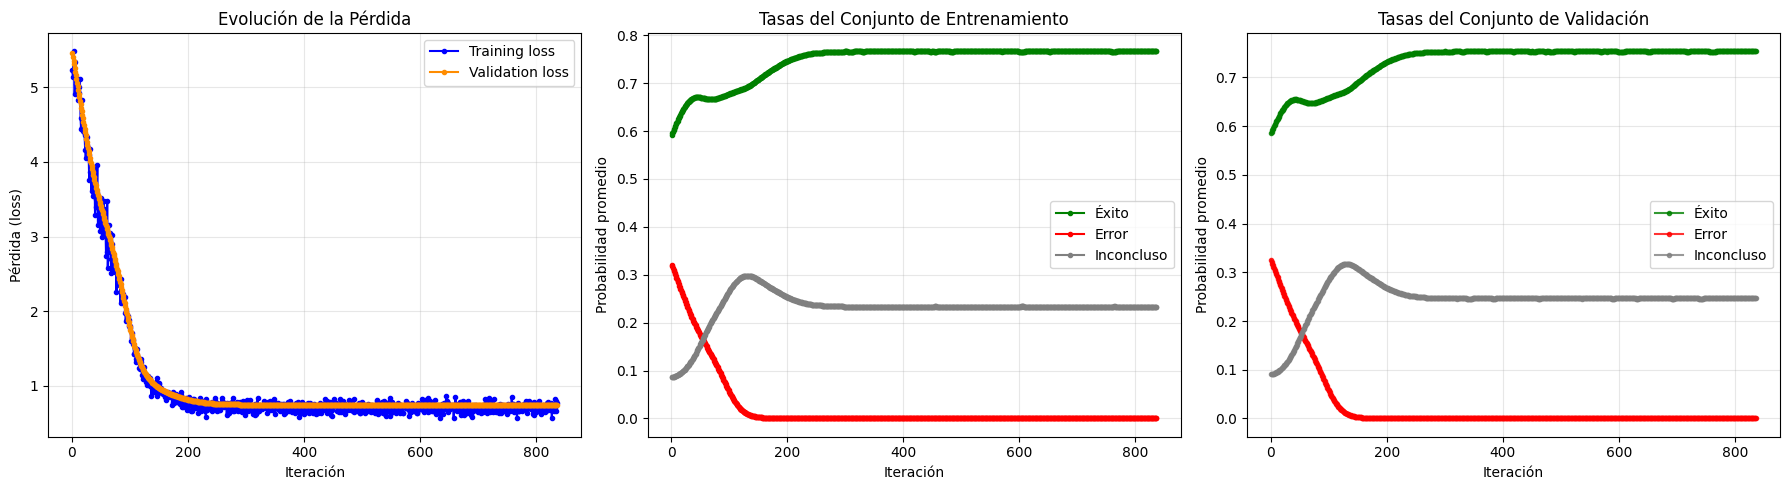

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

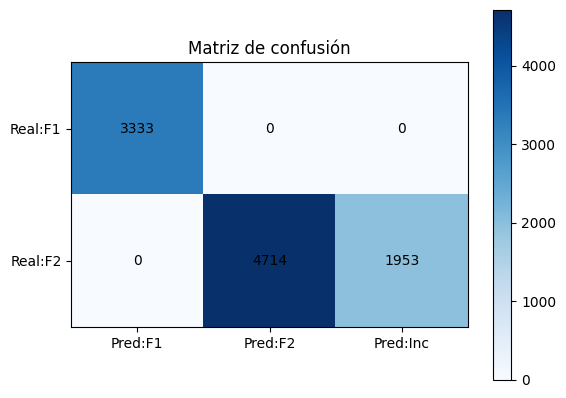

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
